In [ ]:
참고 https://www.youtube.com/watch?v=l_kf9CfZ_8M&list=RDCMUCUlRrGpNRT5jbiV8h5Q_4Fg&index=2

In [ ]:
원본 https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-detect-and-count-objects-in-polygon-zone.ipynb#scrollTo=VEnDHeW1Cvpw

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Detect and Count Objects in Zone

---

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on how to train YOLOv8 Object Detection, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv5
- Install YOLOv8
- Install Supervision
- Download data
- Simple YOLOv8 Shopping Mall Example
- Simple YOLOv8 Subway Example
- Advanced YOLOv5 Market Square Example
- Congratulations

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi  #1

In [ ]:
#2  Roboflow 한복detection 모델다운
# https://universe.roboflow.com/3503koreancharacters1018/350-3-koreancharacters/dataset/3/download

!wget -O HAN.zip https://universe.roboflow.com/ds/xtVwWUPVrL?key=4QgAA8pTK8

In [ ]:
import zipfile #3

with zipfile.ZipFile('/content/HAN.zip') as target_file:
  target_file.extractall('/content/HAN/')

In [ ]:
import os #4

os.remove('/content/HAN.zip')

In [ ]:
!cat /content/HAN/data.yaml #5

In [ ]:
!pip install PyYAML #6

In [ ]:
import yaml #7

data = { 'train': '/content/HAN/train/images/',
        'val':'/content/HAN/valid/images/',
         'test':'/content/HAN/test/images/',
         'names':['1', '2', '4', '6', '7', 'Chinese', 'English', 'Japanese', 'Korean flag', 'KoreanCharacters', 'Lee', 'hanbok'],
         'nc': 12 }

with open('/content/HAN/HAN.yaml', 'w') as f:
  yaml.dump(data, f)

with open('/content/HAN/HAN.yaml', 'r') as f:
  han_yaml=yaml.safe_load(f)
  display(han_yaml)

In [ ]:
!cat /content/HAN/HAN.yaml #8

In [ ]:
import torch   #9
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

In [ ]:
import os #10
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
#11
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

## Install Detectron2

In [ ]:
#12

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

## Install Supervision

In [ ]:
!pip install supervision==0.2.0    #13

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

In [ ]:
# 사전학습된 yolo8모델을 내 데이터로 재학습 (Fine Tuning)하기

In [ ]:
from ultralytics import YOLO    #14

model = YOLO('yolov8n.pt')

In [ ]:
# 15
print(type(model.names), len(model.names))
print(model.names)

In [ ]:
# 16

model.train(data = '/content/HAN/HAN.yaml', epochs=25, patience=100, batch=32, imgsz=416)

In [ ]:
print(type(model.names), len(model.names))  # 17

print(model.names)

## Download data

In [ ]:
#18 내 영상

PASSERBY_PATH = "/content/1021_mozaic.mp4"  # 한복입은사람 수 체크

## Simple YOLOv8 Shopping Mall Example

**NOTE:** Let's start vanilla YOLOv8 inference pipeline.

In [ ]:
# 19     Video Info 동영상 크기 프레임수확인

from supervision import VideoInfo

video_info = VideoInfo.from_video_path(video_path="/content/1021_mozaic.mp4")

video_info

In [ ]:
# 20
video_info.resolution_wh

**NOTE:** In this demo, our goal is primarily to detect people. Therefore, let's filter out detections related to other classes. By the way, we can also replace our bounding box labels with more human-friendly ones.


0: 736x1280 7 hanboks, 190.6ms
Speed: 10.0ms preprocess, 190.6ms inference, 10.0ms postprocess per image at shape (1, 3, 736, 1280)


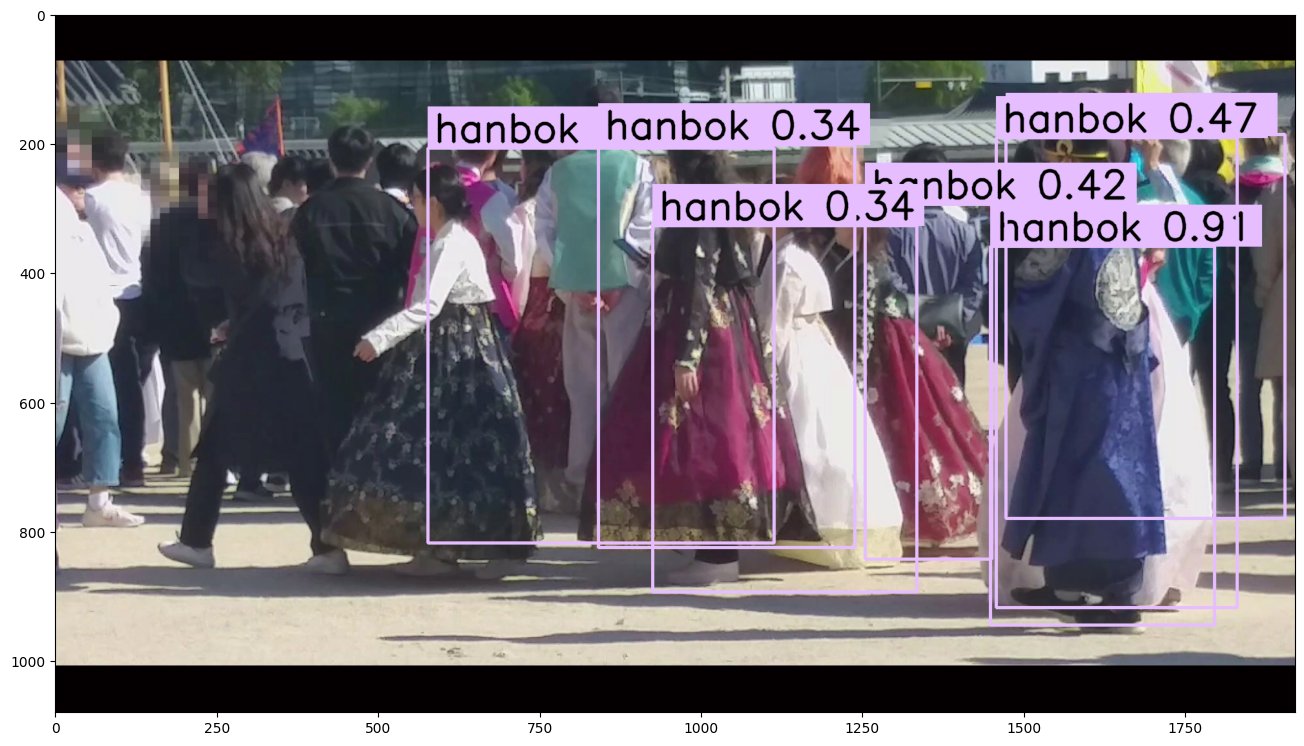

In [ ]:
#21  한복 개체탐지 수

import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(PASSERBY_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
#results = model(frame, imgsz=1920)[0] # 별변화없이 아무런 detect도 안함
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 11] #모델 11번째 class 한복

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections] #
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
#22  predict동영상저장 // 여기까지   한복 탐지 개체 수  동영상 저장 CLASS한복 11


import numpy as np
import supervision as sv

# initiate polygon zone

#polygon = np.array([
#    [0, 0],
#    [1800, 0],
#    [1750, 850],
#    [0, 850]
#])

polygon = np.array([
    [0, 0],
    [1880, 0],
    [1880, 1000],
    [0, 1000]
])
video_info = sv.VideoInfo.from_video_path(PASSERBY_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[detections.class_id == 11]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=PASSERBY_PATH, target_path="/1021_mozaic_2_result.mp4", callback=process_frame)

from IPython import display
display.clear_output()

# GPU로 VideoInfo(width=1920, height=936, fps=30, total_frames=769)
# CPU 꽤 오래걸림 40분? 34분28초